In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from decimal import Decimal, ROUND_DOWN


In [ ]:
wavelength = 632.8 #[nm]
l = 15e7 #[nm]
sigma_l = 0.01e7 #[nm]
sigma_w = 0.002 #[nm]

In [ ]:
 #Carga de datos
Bobbin = pd.read_excel("Datos_Magnetostriccion.xlsx",
                       sheet_name="Bobina")
Niquel = pd.read_excel("Datos_Magnetostriccion.xlsx",
                       sheet_name="Niquel")
Hierro = pd.read_excel("Datos_Magnetostriccion.xlsx",
                       sheet_name="Cobre")

## Caracterización de la bobina

In [ ]:
# Corriente y campo magnético de la bobina
magnetic_field = (Bobbin["Campo magnetico (mT)"]. # [mT]
                        astype(float).to_numpy())
current_bobbin = (Bobbin["Corriente (A)"]. # [A]
                        astype(float).to_numpy())


In [ ]:
coefficients,cov=np.polyfit(current_bobbin,magnetic_field,1,cov=True)
poly=np.poly1d(coefficients)
y_trend = poly(current_bobbin)
r2=r2_score(magnetic_field,poly(current_bobbin))
residuals=magnetic_field-poly(current_bobbin)
normalised_residuals=residuals/np.std(residuals)
m, b = coefficients[0], coefficients[1]
sigma_m, sigma_b = np.sqrt(cov[0,0]), np.sqrt(cov[1,1])
r2= Decimal(r2)
r2 = r2.quantize(Decimal("0.00"), rounding=ROUND_DOWN)

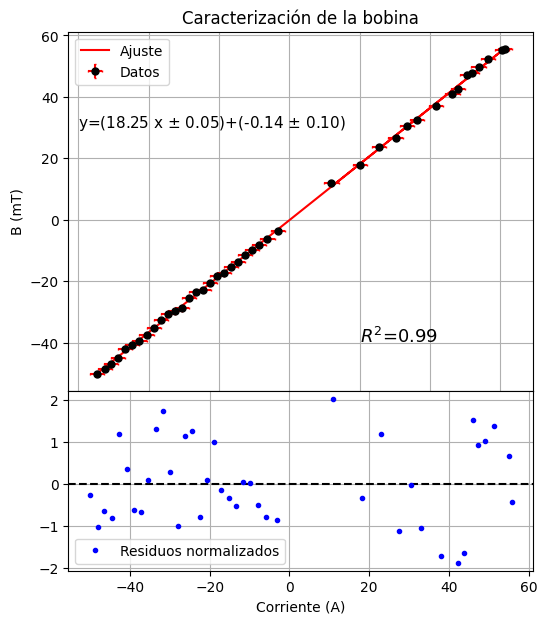

In [ ]:
fig, axs = plt.subplots(2,1, sharex=False,figsize=(6,7), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)

axs[0].plot(current_bobbin,y_trend, label="Ajuste", ls="-", c="r")
axs[0].errorbar(current_bobbin,magnetic_field, yerr =[0.1]*len(magnetic_field), xerr = [0.1]*len(magnetic_field), fmt="o", label="Datos", ecolor="r", capsize=1,c="k", markersize=5)
axs[0].set_title("Caracterización de la bobina")
axs[0].set_ylabel('B (mT)')
axs[0].legend(loc=0)
axs[0].grid("major")
axs[0].text(1,-40,f'$R^2$={r2}',fontsize=13)
axs[0].text(-3,30,f'y=({m:.2f} x $\pm$ {sigma_m:.2f})+({b:.2f} $\pm$ {sigma_b:.2f})',fontsize=11)

axs[0].legend()

axs[1].axhline(y=0,color='k',linestyle='--')
axs[1].plot( poly(current_bobbin),normalised_residuals, ".b", label ="Residuos normalizados")
axs[1].grid("major")
axs[1].set_xlabel('Corriente (A)')
axs[1].legend()

plt.savefig("Ajuste lineal.jpeg")



In [ ]:
estimados = {"Pendiente": [f'{m:.2f} $\pm$ {sigma_m:.2f}'], "Intercepto": [f'{b:.2f} $\pm$ {sigma_b:.2f}']}
estimados = pd.DataFrame(estimados)
latex_code = estimados.to_latex(index=False, escape=False)
print(latex_code)

\begin{tabular}{ll}
\toprule
Pendiente & Intercepto \\
\midrule
18.25 $\pm$ 0.05 & -0.14 $\pm$ 0.10 \\
\bottomrule
\end{tabular}



### Curvas caracteristicas

In [ ]:
# Corriente y número de minímos del niquel y cobre

current_niquel = (Niquel["Corriente (A)"]. # [A]
                        astype(float).to_numpy())
minimum_number_n = (Niquel["Numero minimos "].
                        astype(float).to_numpy())

current_Hierro = (Hierro["Corriente (A)"]. # [A]
                        astype(float).to_numpy())
minimum_number_c = (Hierro["Numero de minimos"].
                        astype(float).to_numpy())

In [ ]:
sigma_delta_l_hierro = minimum_number_c* wavelength/(2*l)*np.sqrt((sigma_l/l)**2+(sigma_w/wavelength)**2)
sigma_delta_l_niquel = minimum_number_n* wavelength/(2*l)*np.sqrt((sigma_l/l)**2+(sigma_w/wavelength)**2)
sigma_B_niquel =  np.sqrt(sigma_m + current_niquel**2 * sigma_b + 2 * current_niquel * cov[0, 1])
sigma_B_Hierro =  np.sqrt(sigma_m + current_Hierro**2 * sigma_b + 2 * current_Hierro * cov[0, 1])
sigma =[sigma_B_niquel, sigma_B_Hierro]
sigma_delta_l = [sigma_delta_l_niquel, sigma_delta_l_hierro]
sigma_delta_l_hierro

array([0.00000000e+00, 1.40623802e-09, 0.00000000e+00])

In [ ]:
def delta_l_tables(current, minimum, sigma, sigma_delta):
  B_1 = poly(current)
  delta= minimum * wavelength /2
  delta /=l
  delta_1 =[f"{delta[i]:.2e} $\pm$ {abs(sigma_delta[i]):.1e}" for i in range(len(delta))]
  current = [f"{i:.1f}" for i in current]
  B = [f"{B_1[i]:.1f} $\pm$ {sigma[i]:.1f}" for i in range(len(B_1))]
  df = {"I $\pm$ 0.01 (A)":current, "B $\pm$(mT)": B, f"$\delta$l/l": delta_1}
  df = pd.DataFrame(df)
  latex_code = df.to_latex(index=False, escape=False)
  return latex_code, delta, B_1

In [ ]:
latex_niquel, delta_l_niquel, B_niquel = delta_l_tables(current_niquel, minimum_number_n,
                                                        sigma_B_niquel, sigma_delta_l_niquel)
latex_Hierro, delta_l_Hierro, B_Hierro = delta_l_tables(current_Hierro, minimum_number_c,
                                                        sigma_B_Hierro, sigma_delta_l_hierro)
delta = [delta_l_niquel, delta_l_Hierro]
B = [B_niquel, B_Hierro]
nombres = ["Niquel", "Hierro"]
print(latex_Hierro)

\begin{tabular}{lll}
\toprule
I $\pm$ 0.01 (A) & B $\pm$(mT) & $\delta$l/l \\
\midrule
0.2 & 2.8 $\pm$ 0.2 & 0.00e+00 $\pm$ 0.0e+00 \\
0.9 & 17.2 $\pm$ 0.4 & 2.11e-06 $\pm$ 1.4e-09 \\
2.3 & 42.4 $\pm$ 0.8 & 0.00e+00 $\pm$ 0.0e+00 \\
\bottomrule
\end{tabular}



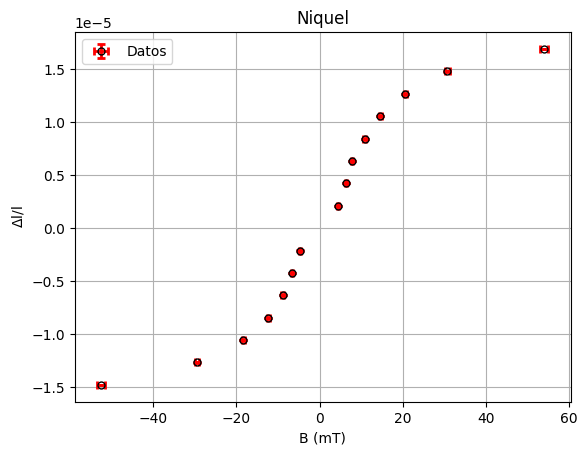

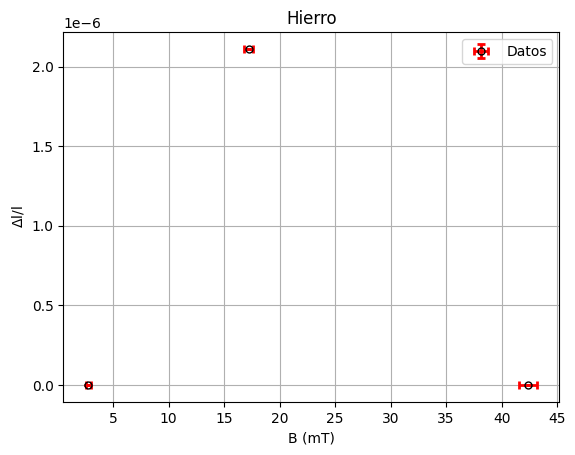

In [ ]:
for i in range(0,2):
  plt.errorbar(B[i], delta[i],
             yerr= abs(sigma_delta_l[i]),
             xerr=sigma[i],
             fmt="o",
             ecolor="r",
             capsize=3,
             capthick=2,
             elinewidth=2,
             markerfacecolor="none",
             markeredgecolor="k",
             markersize=5,
             label="Datos")
  plt.legend()
  plt.title(nombres[i])
  plt.ylabel("$\Delta$l/l")
  plt.xlabel("B (mT)")
  plt.grid("major")
  plt.show()